# Setup

In [ ]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

from source.Data import get_maang_data_default
maang = get_maang_data_default()

<Axes: title={'center': 'MAANG companies stock prices'}, xlabel='Date', ylabel='Stock price'>

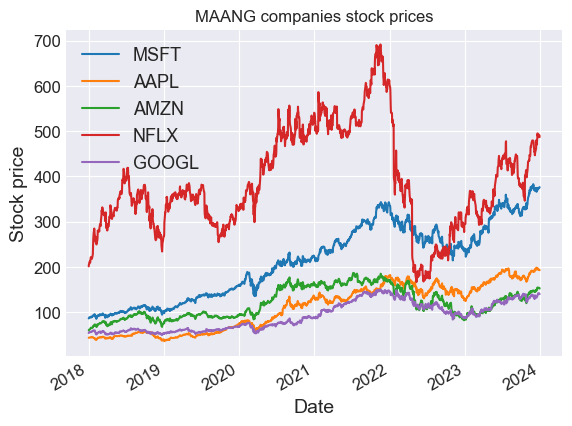

In [ ]:
maang.plot(title='MAANG companies stock prices', ylabel='Stock price', xlabel='Date', grid=True)

In [ ]:
maang.head()

,MSFT,AAPL,AMZN,NFLX,GOOGL
Date,,,,,
2018-01-02,85.949997,43.064999,59.450500,201.070007,53.660500
2018-01-03,86.349998,43.057499,60.209999,205.050003,54.576000
2018-01-04,87.110001,43.257500,60.479500,205.630005,54.787998
2018-01-05,88.190002,43.750000,61.457001,209.990005,55.514500
2018-01-08,88.279999,43.587502,62.343498,212.050003,55.710499


##### 1ere analyse pré analyse


In [ ]:
### test de stationarité:

from statsmodels.tsa.stattools import adfuller
for stock in maang.columns:
    adf_test = adfuller(maang[stock])
    print(f'p-value: {adf_test[1]}')

## très grandes p valeurs donc pas stationnaires, netflix l'est deja plus que les autres

p-value: 0.9145653907112465
p-value: 0.8822398141495198
p-value: 0.31087826984905276
p-value: 0.2211641911718643
p-value: 0.8977735289003599


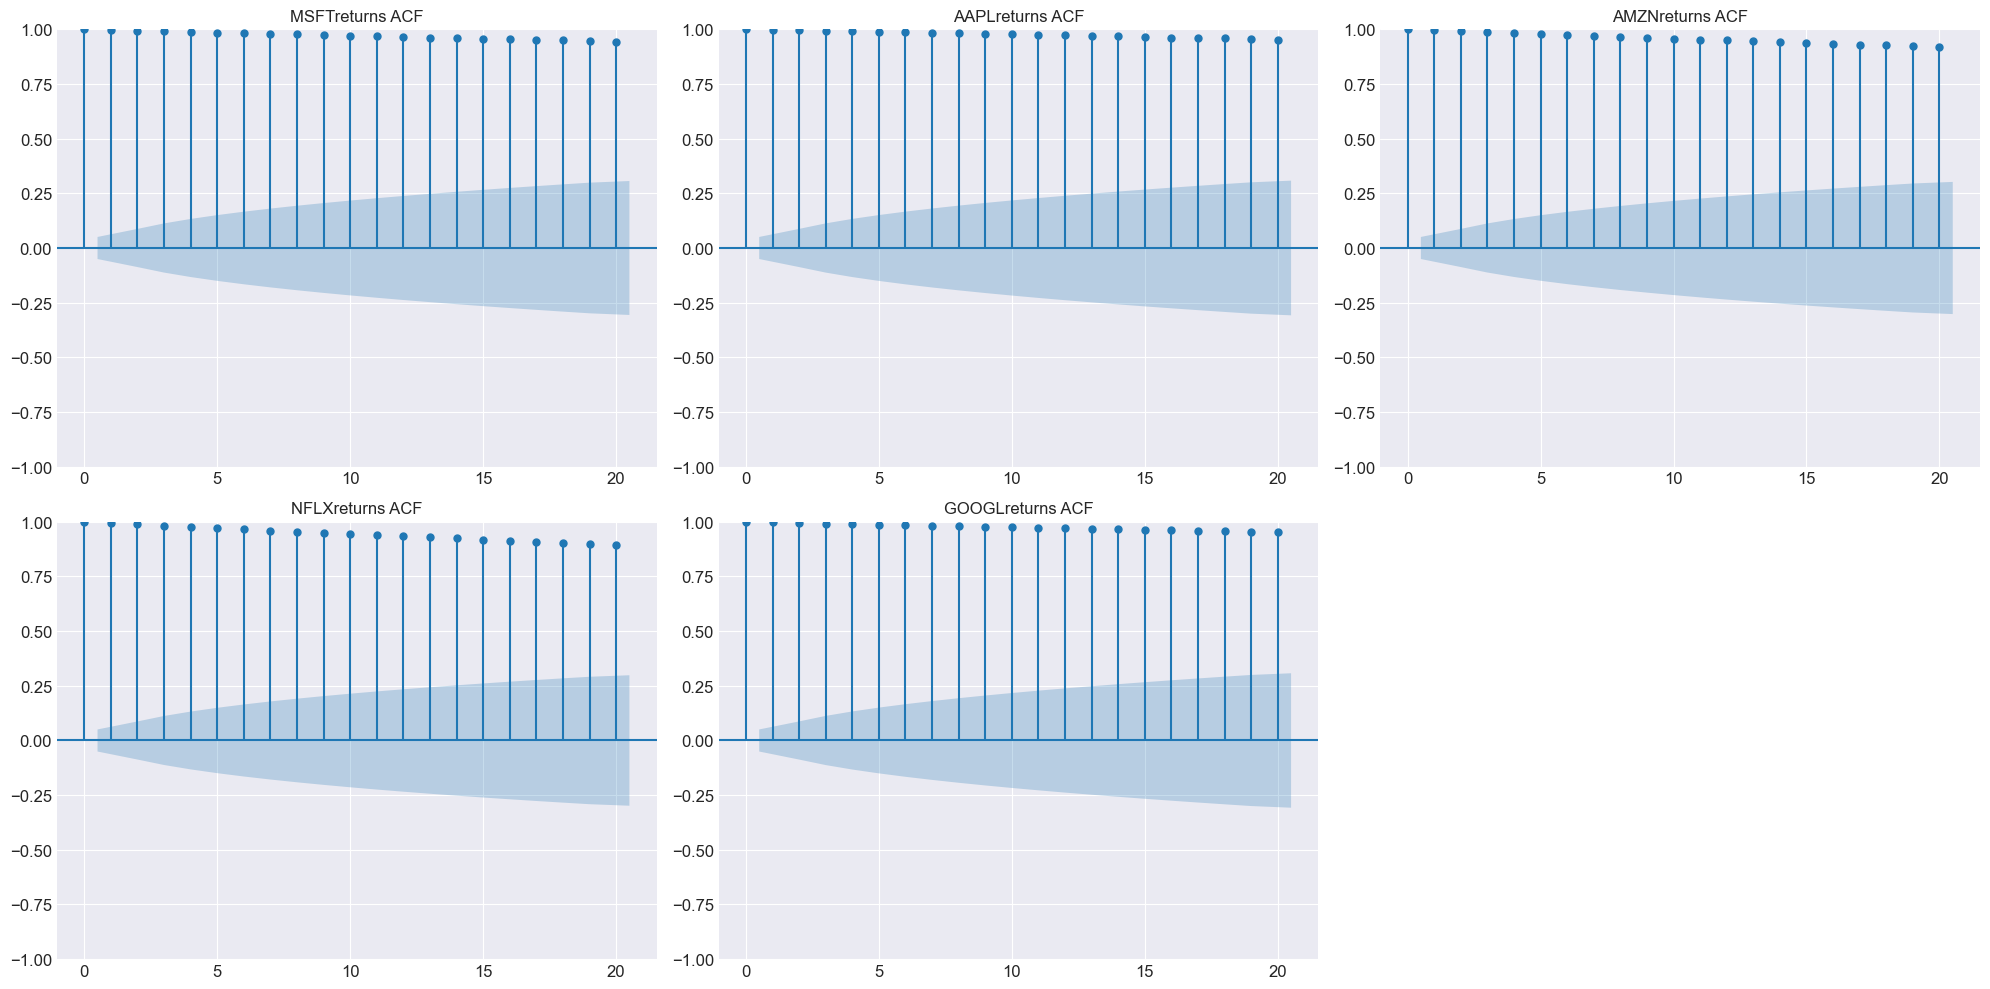

In [ ]:
## confirmation par les ACC

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang.columns):
    plt.subplot(2, 3, i + 1)
    sm.graphics.tsa.plot_acf(maang[stock], lags=20, ax=plt.gca())
    plt.title(stock + 'returns ACF')
plt.tight_layout()
plt.show()

## très autocorrelé

# Séries temporelles linéaires

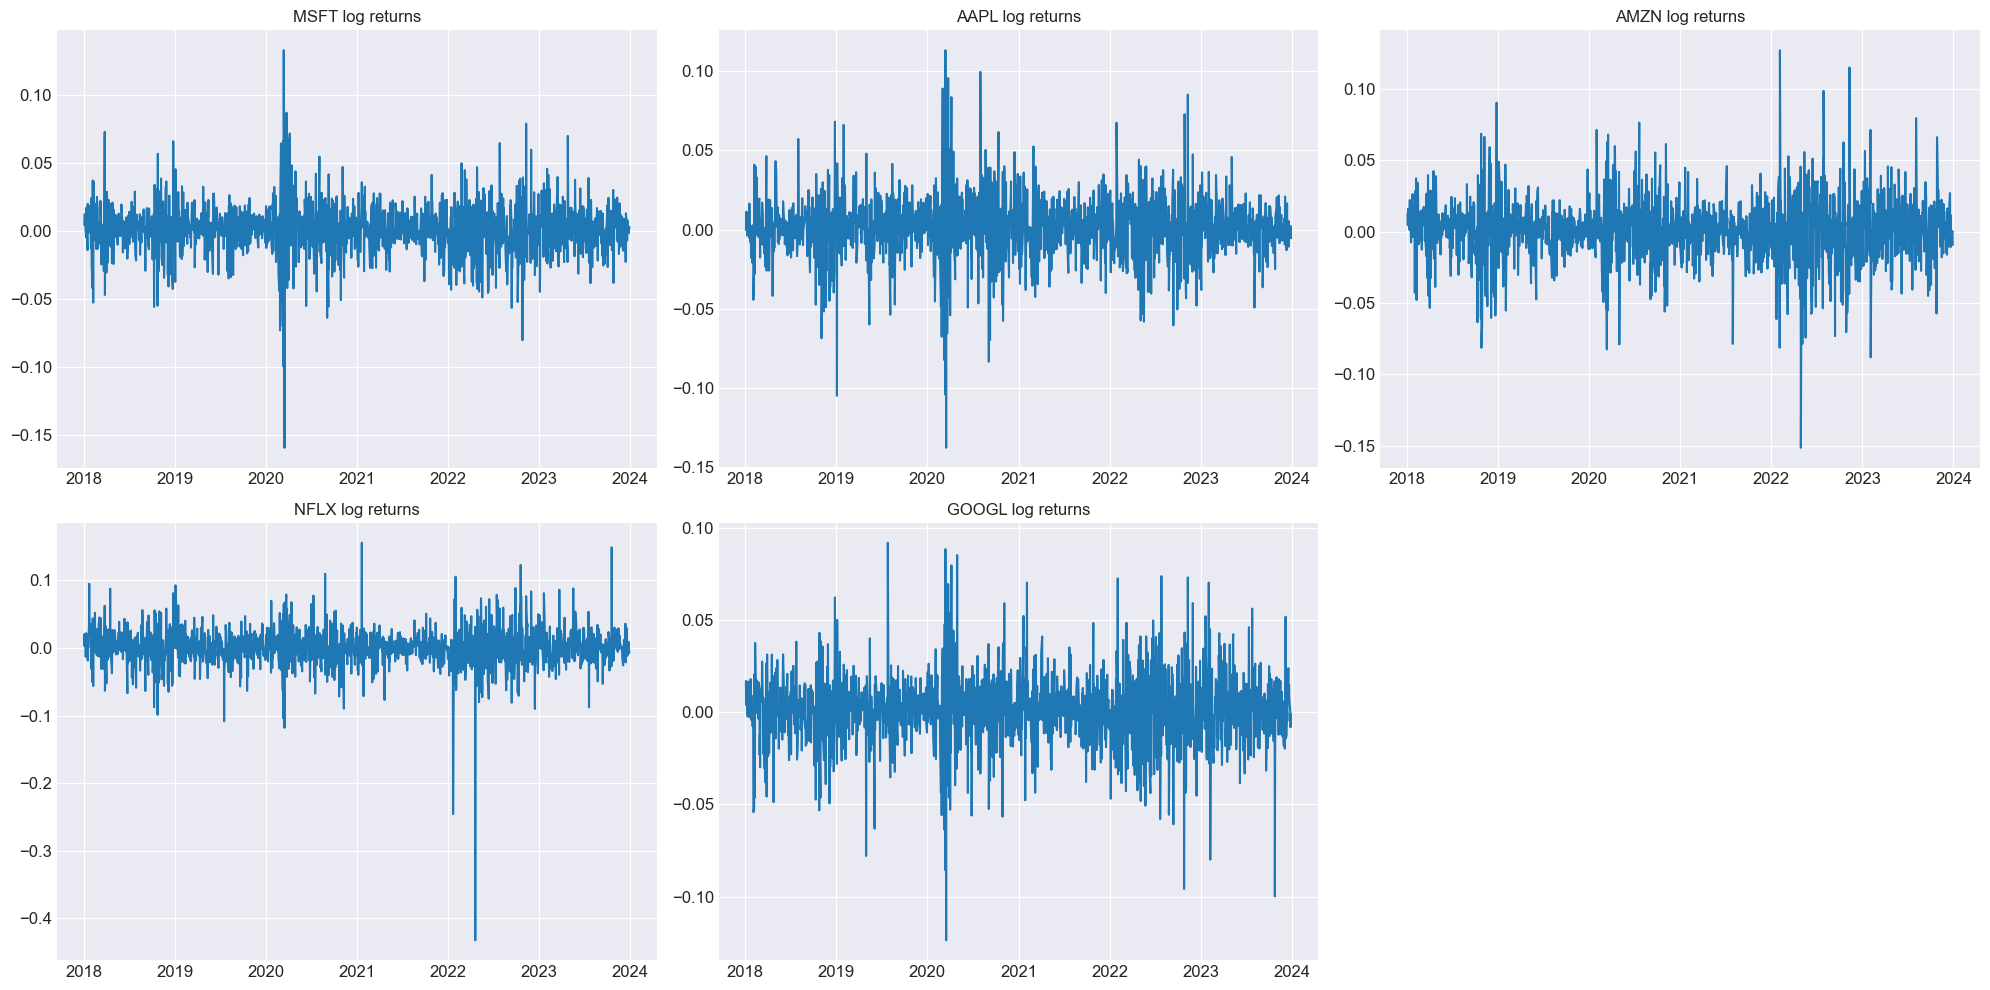

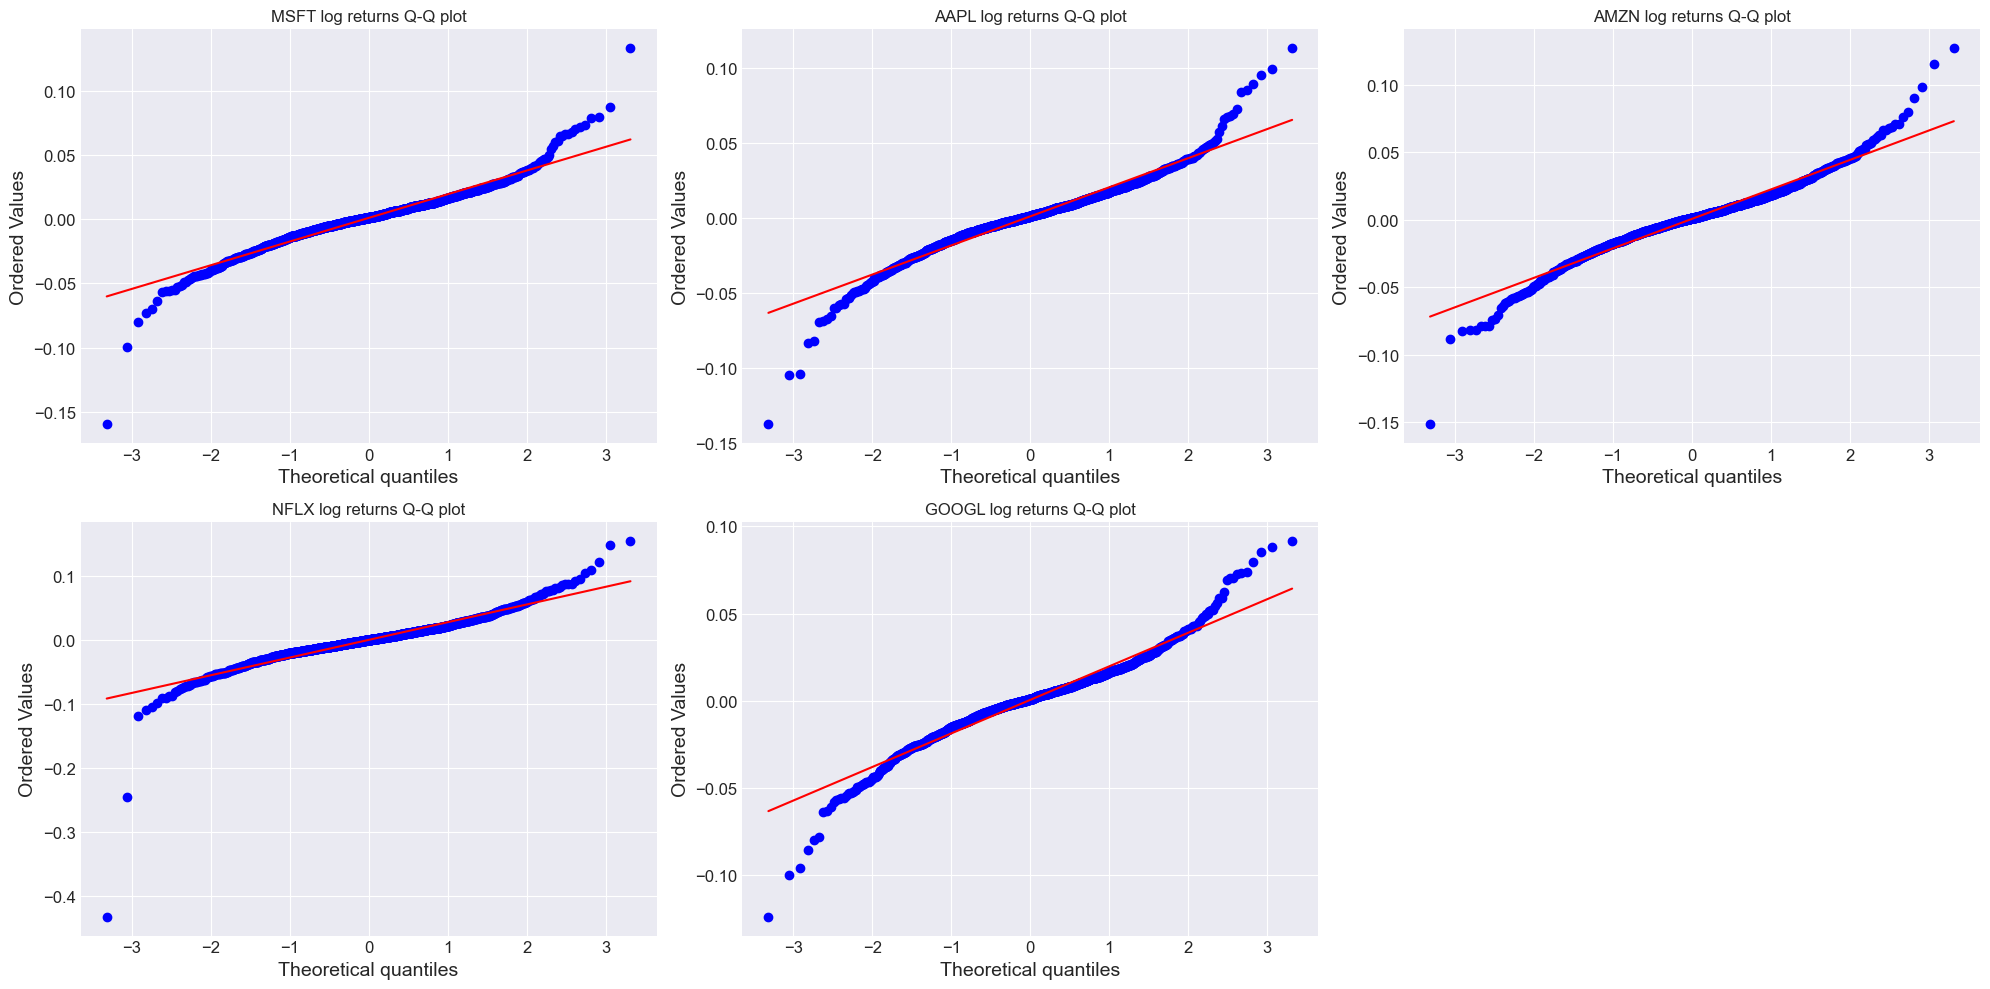

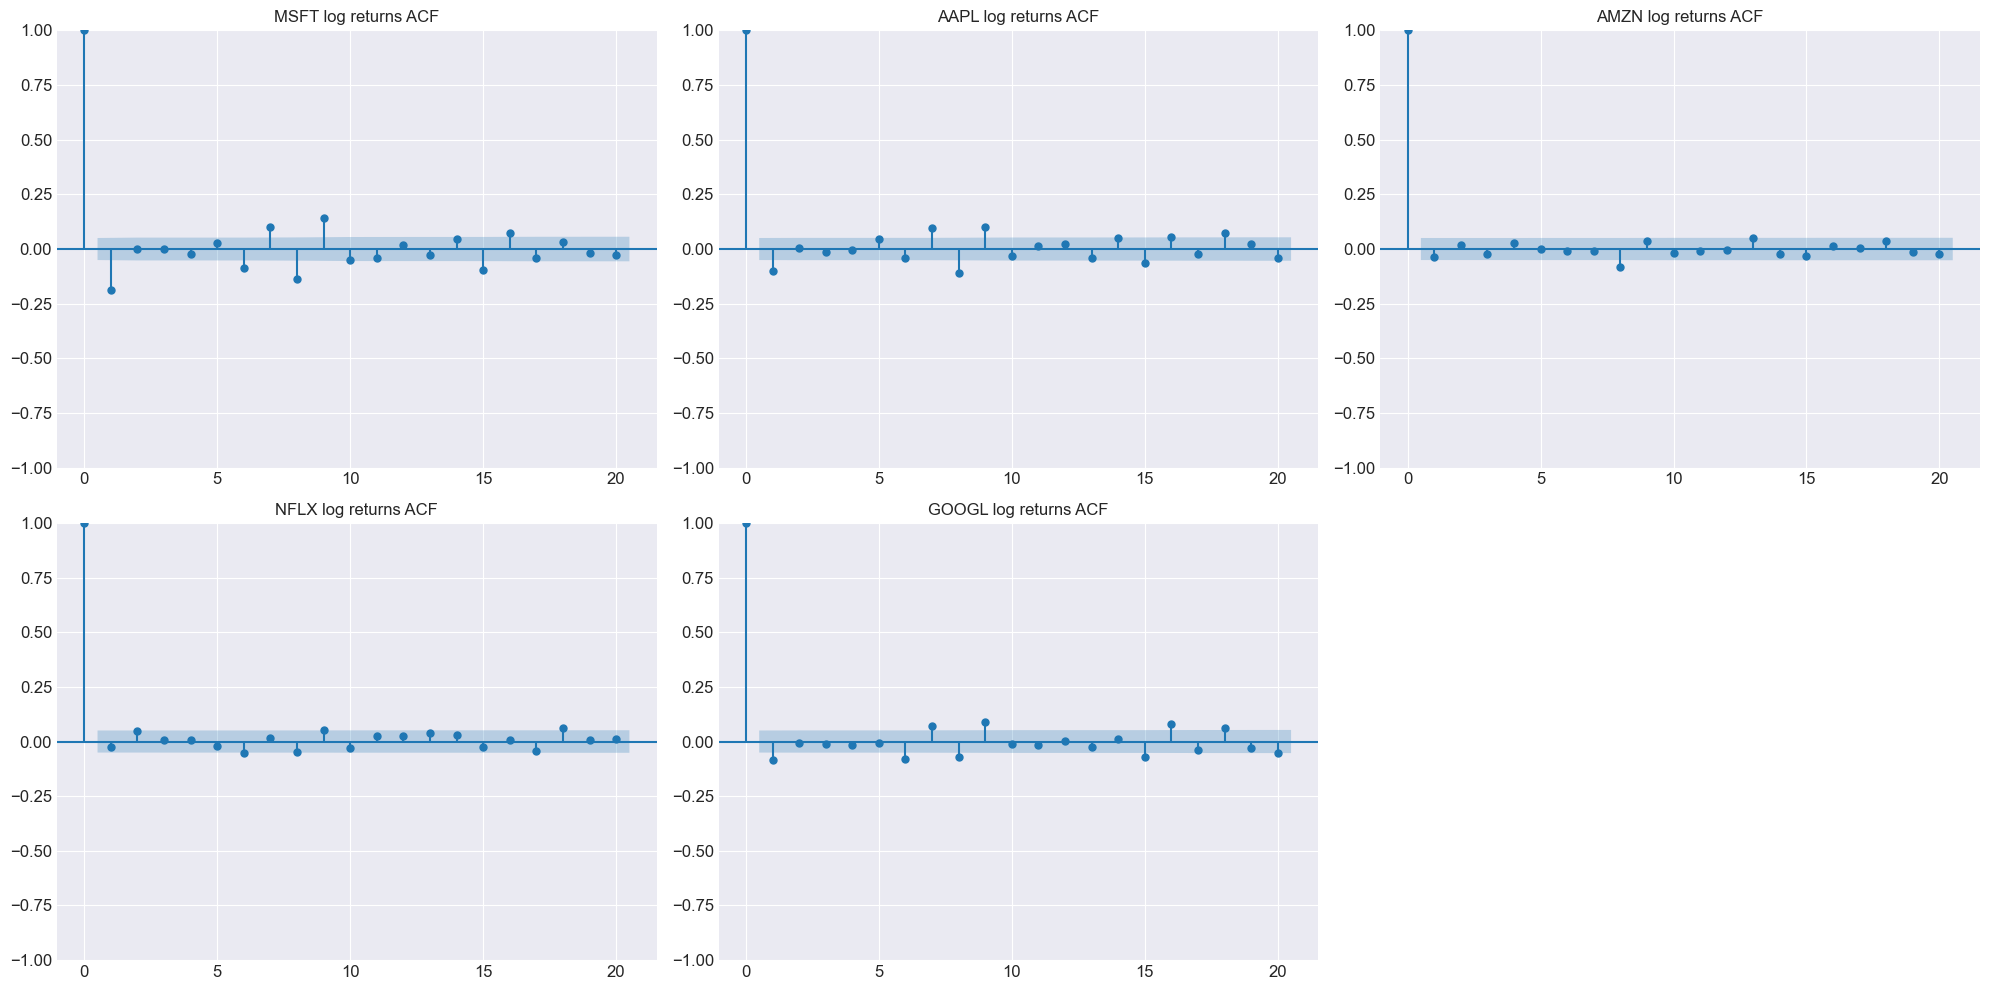

In [ ]:
maang_log_returns = np.log(maang / maang.shift(1)).dropna()
## log interessant car plus gros indicateur de c'est la merde quand action tombe vers 0 car valeurs negatives.
## AUssi upper trend dans non log non stationaiee ici transformation rend deja stationnaire un peu plus

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    plt.plot(maang_log_returns[stock])
    plt.title(stock + ' log returns')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    sps.probplot(maang_log_returns[stock], plot=plt, dist='norm')
    plt.title(stock + ' log returns Q-Q plot')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    sm.graphics.tsa.plot_acf(maang_log_returns[stock], lags=20, ax=plt.gca())
    plt.title(stock + ' log returns ACF')
plt.tight_layout()
plt.show()

1 voir 2 termes de ACC non negligeables donc ARIMA en (p,d,1-2)

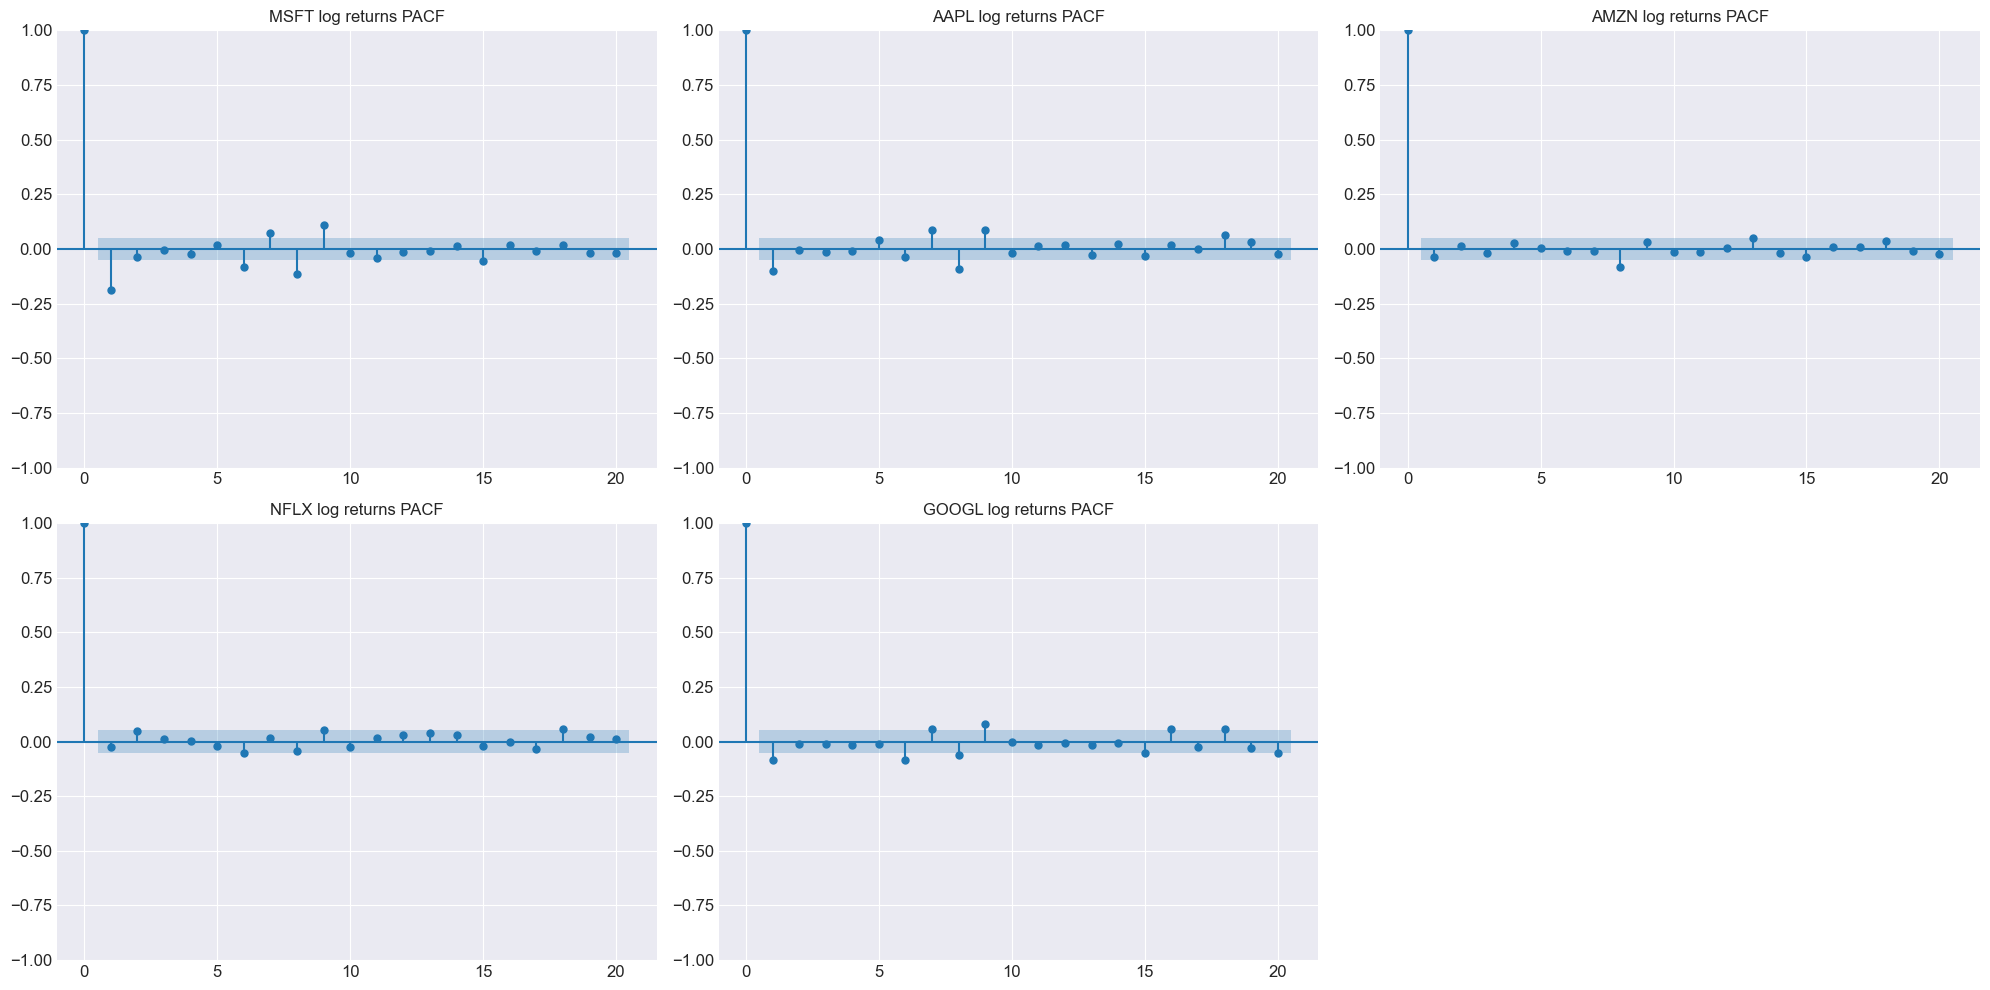

In [ ]:
### partial auto correlation PCC 

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    sm.graphics.tsa.plot_pacf(maang_log_returns[stock], lags=20, ax=plt.gca())
    plt.title(stock + ' log returns PACF')
plt.tight_layout()
plt.show()

In [ ]:
for stock in maang_log_returns.columns:
    kurtosis = np.mean((maang_log_returns[stock] - maang_log_returns[stock].mean()) ** 4) / np.var(maang_log_returns[stock]) ** 2
    normalized_kurtosis = kurtosis - 3
    print(f'Kurtosis normalisé pour {stock}:\t {round(kurtosis, 3)}')

    ## netflix très gros, ca veut dire quoi ?

Kurtosis normalisé pour MSFT:	 9.835
Kurtosis normalisé pour AAPL:	 8.049
Kurtosis normalisé pour AMZN:	 6.913
Kurtosis normalisé pour NFLX:	 36.722
Kurtosis normalisé pour GOOGL:	 6.828


1 terme non negligeable de PACC donc ARIMA en (1,d,q)

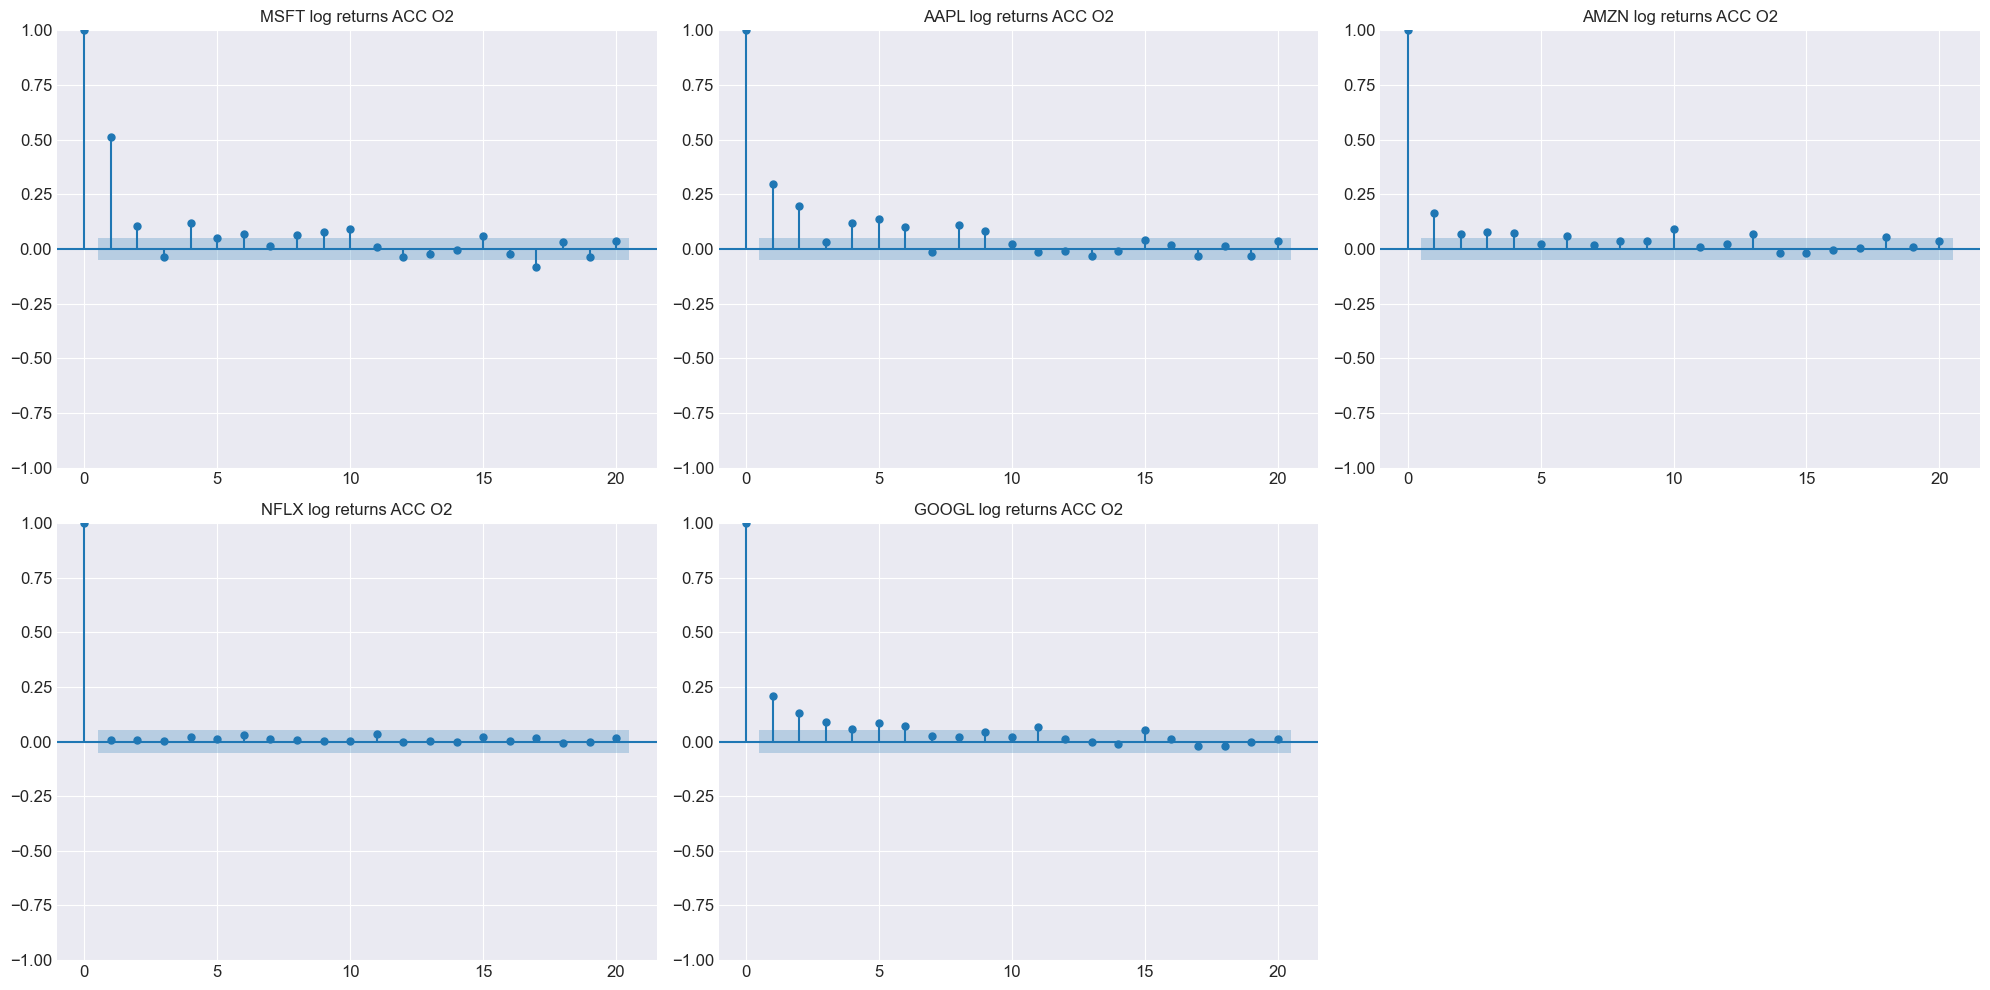

In [ ]:
## ACC ordre 2 (normalement grosse ACC car cest pas du white noise non plus)


plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    sm.graphics.tsa.plot_pacf(maang_log_returns[stock]**2, lags=20, ax=plt.gca())
    plt.title(stock + ' log returns ACC O2')
plt.tight_layout()
plt.show()

In [ ]:
### test de stationarité:

from statsmodels.tsa.stattools import adfuller
for stock in maang_log_returns.columns:
    adf_test = adfuller(maang_log_returns[stock])
    print(f'p-value: {adf_test[1]}')

## proche de 0, donc bcp plus stationnaire dejà, mieux qu'avant donc transofmztion passage au log efficace


p-value: 2.8879321595745938e-24
p-value: 1.5102636211576394e-22
p-value: 0.0
p-value: 0.0
p-value: 1.8325860256125685e-24


Très stationnaire donc ARIMA en (p,0,q) pas besoin de differencier.

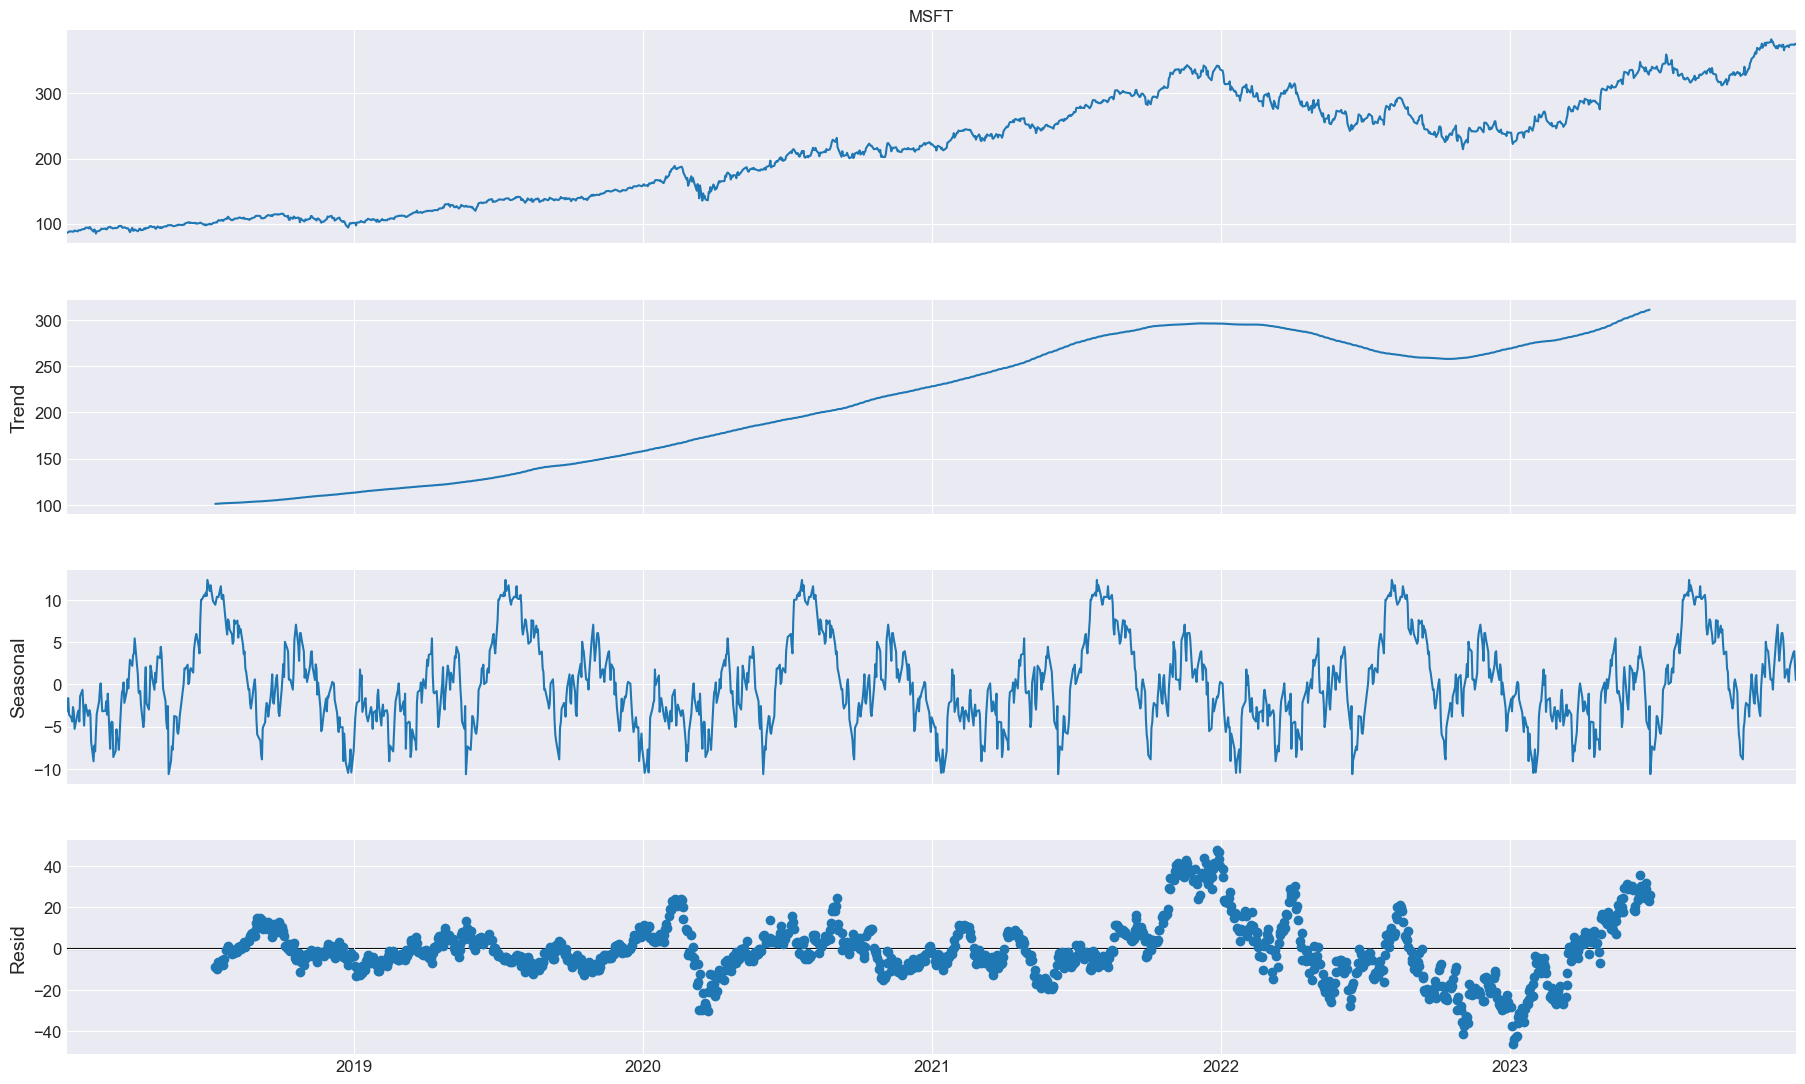

In [ ]:
## Seasonality: belle formule dans le cours
decompose = sm.tsa.seasonal_decompose(maang['MSFT'], model='additive', period=258) # The frequncy is annual

figure = decompose.plot()
figure.set_figheight(12)
figure.set_figwidth(20)

Utile pour ARIMA car predire la tendance est plus simple que predire le prix. Possibilité de test de modèle.

##### **Series temporelles linéaires : ARIMA**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

dates = pd.date_range(start='2018-01-01', periods=1565, freq='B')  # Business days
data = pd.Series(maang['MSFT'], index=dates)  # Simulated log returns

# Fit ARIMA model
model_101 = ARIMA(data, order=(1,0,1))
model_101_fit = model_101.fit()

model_102 = ARIMA(data, order=(1,0,2))
model_102_fit = model_102.fit()

# Print out the summary
print(model_101_fit.summary())
print(model_102_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   MSFT   No. Observations:                 1565
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4262.872
Date:                Sat, 06 Apr 2024   AIC                           8533.743
Time:                        19:14:24   BIC                           8555.166
Sample:                    01-01-2018   HQIC                          8541.707
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        213.7670     94.146      2.271      0.023      29.244     398.290
ar.L1          0.9995      0.001    864.553      0.000       0.997       1.002
ma.L1         -0.1257      0.018     -7.120      0.0

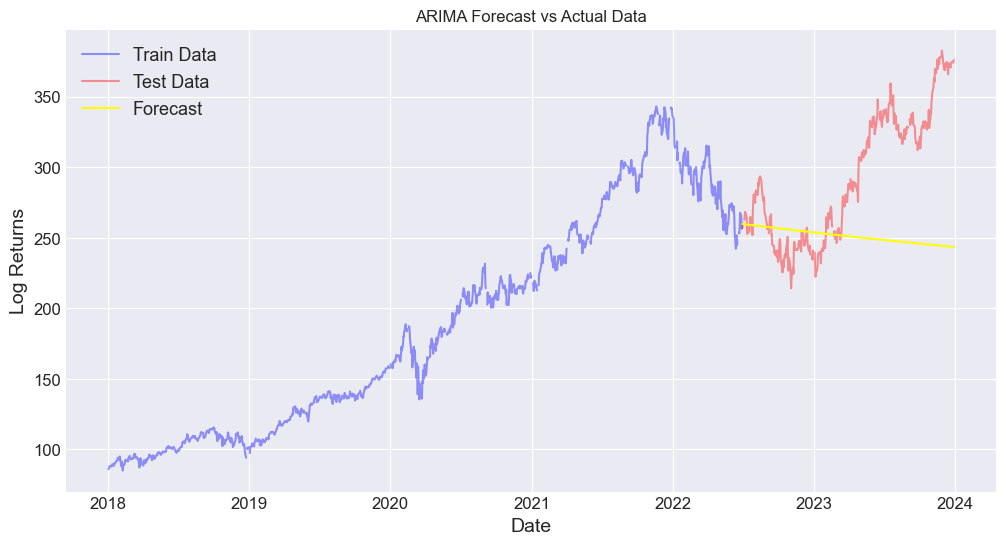

In [ ]:
# Splitting the data into train and test sets
train_size = int(len(data) * 0.75)  
train, test = data[:train_size], data[train_size:]

# Fit ARIMA model on Train data
model = ARIMA(train, order=(1,0,1))  # You can adjust the order based on your specific needs
model_fit = model.fit()


# Forecast
forecast = model_fit.get_forecast(len(test))
print(forecast)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data', color='blue', alpha=0.4)
plt.plot(test.index, test, label='Test Data', color='red', alpha=0.4)
plt.plot(test.index, forecast.predicted_mean, label='Forecast', color='yellow')
plt.title('ARIMA Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

c:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_mode

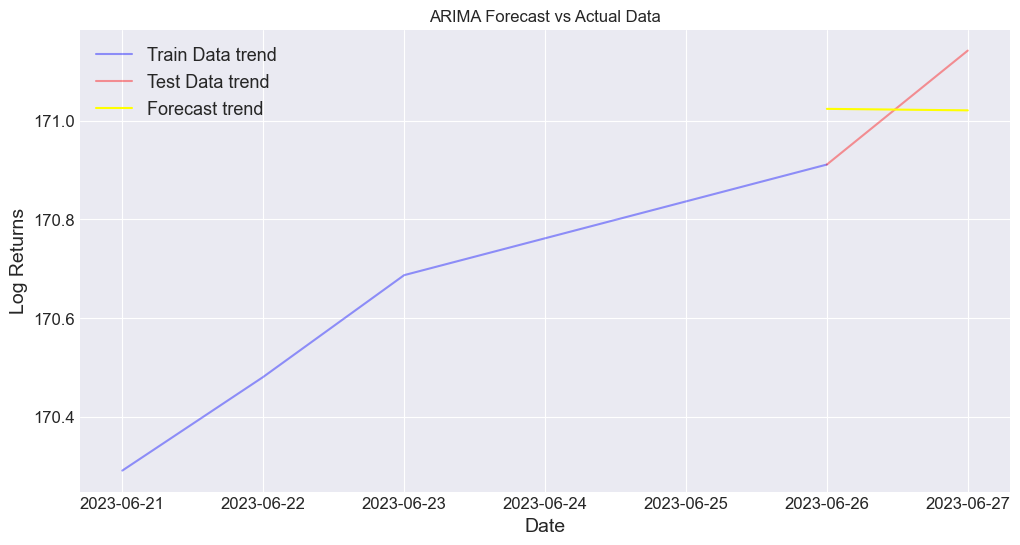

In [ ]:
decompose = sm.tsa.seasonal_decompose(maang['AAPL'], model='additive', period=258) # The frequncy is annual

trend = decompose.trend
trend_clean = trend.dropna()




train_tr, test_tr = trend_clean[:-1], trend_clean[-2:]

# Fit ARIMA model on Train data
model = ARIMA(train_tr, order=(1,0,1))  # You can adjust the order based on your specific needs
model_fit = model.fit()


# Forecast
forecast = model_fit.forecast(2)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_tr.index[-4:], train_tr[-4:], label='Train Data trend', color='blue', alpha=0.4)
plt.plot(test_tr.index, test_tr, label='Test Data trend', color='red', alpha=0.4)
plt.plot(test_tr.index, forecast, label='Forecast trend', color='yellow')
plt.title('ARIMA Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

##### **Copules** (bart)

##### **GARCH forecasting** (volatility forecasting)

In [ ]:
from arch import arch_model
models = []
models_fit = []

for stock in maang_log_returns.columns:
    model = arch_model(100*maang_log_returns[stock], p=1, q=1)
    models.append(model)
    model_fit = model.fit()
    models_fit.append(model_fit)
    print(model_fit.summary())


## very low standard error on estimated parameters, on estime par maximum de vraissemblence ici

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7667.7351819315645
Iteration:      2,   Func. Count:     14,   Neg. LLF: 3334.8851732690237
Iteration:      3,   Func. Count:     23,   Neg. LLF: 3448.7813191553682
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3064.6528472613672
Iteration:      5,   Func. Count:     37,   Neg. LLF: 2905.977675985745
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2906.0605947718013
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2905.9555883585303
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2905.954244050007
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2905.954144977411
Iteration:     10,   Func. Count:     62,   Neg. LLF: 2905.954144978021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2905.954144977411
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results         

C:\Users\souna\AppData\Local\Temp\ipykernel_44664\2820716632.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


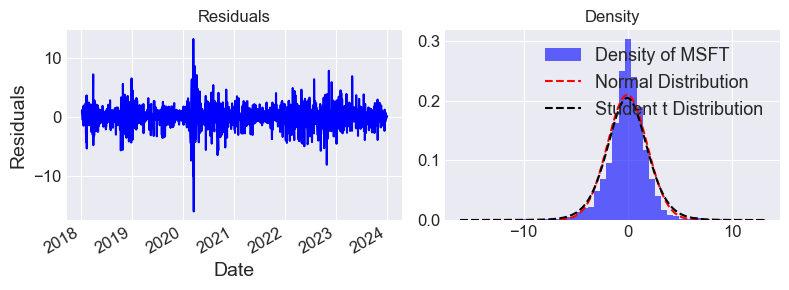

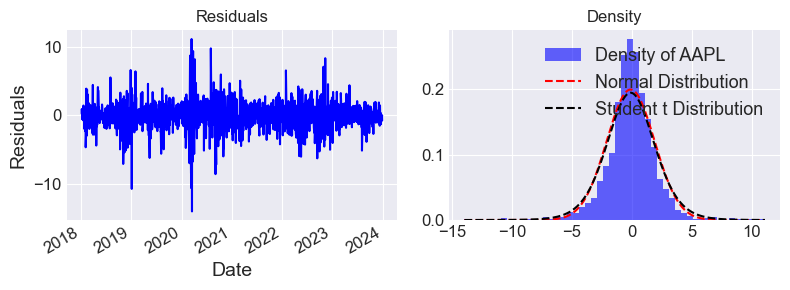

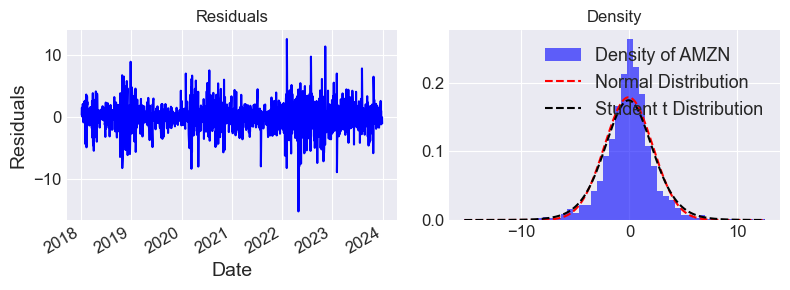

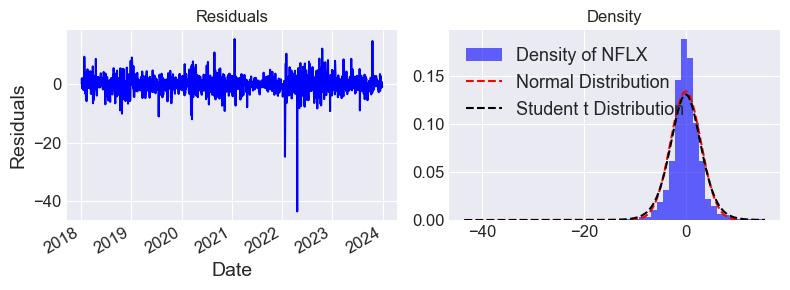

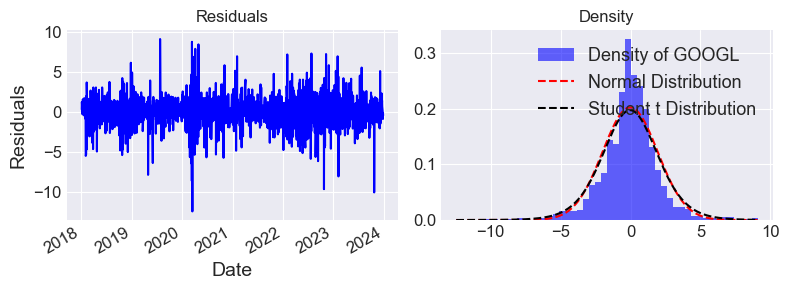

In [ ]:
## etude des résidus normalement c'est du white noise si le modèle est bon
from scipy import stats
plt.style.use('seaborn-darkgrid')

for j, stock in enumerate(maang_log_returns.columns):
    res = models_fit[j].resid[1:]

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    res.plot(color='blue', title=f'Residuals of {stock}')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.title('Residuals')

    x = np.linspace(res.min(), res.max(), 3000)
    res = np.array(res)
    normal_density = stats.norm.pdf(x, np.mean(res), np.std(res))
    t_density = stats.t.pdf(x, 10, np.mean(res), np.std(res))
    plt.subplot(1, 2, 2)
    plt.hist(res, color='blue', label=f'Density of {stock}', bins=len(res)//30, alpha=0.5, density=True)
    plt.plot(x, normal_density, label='Normal Distribution', color='red', linestyle='--')
    plt.plot(x, t_density, label='Student t Distribution', color='black', linestyle='--')
    plt.legend(loc='best')
    plt.title('Density')

    plt.tight_layout()
    plt.show()


Here higher values than normakl distribution, so leptokurtosis means we underestimate risk by comparing it to normal dist whereas it has fatter tails. Maybe student better.

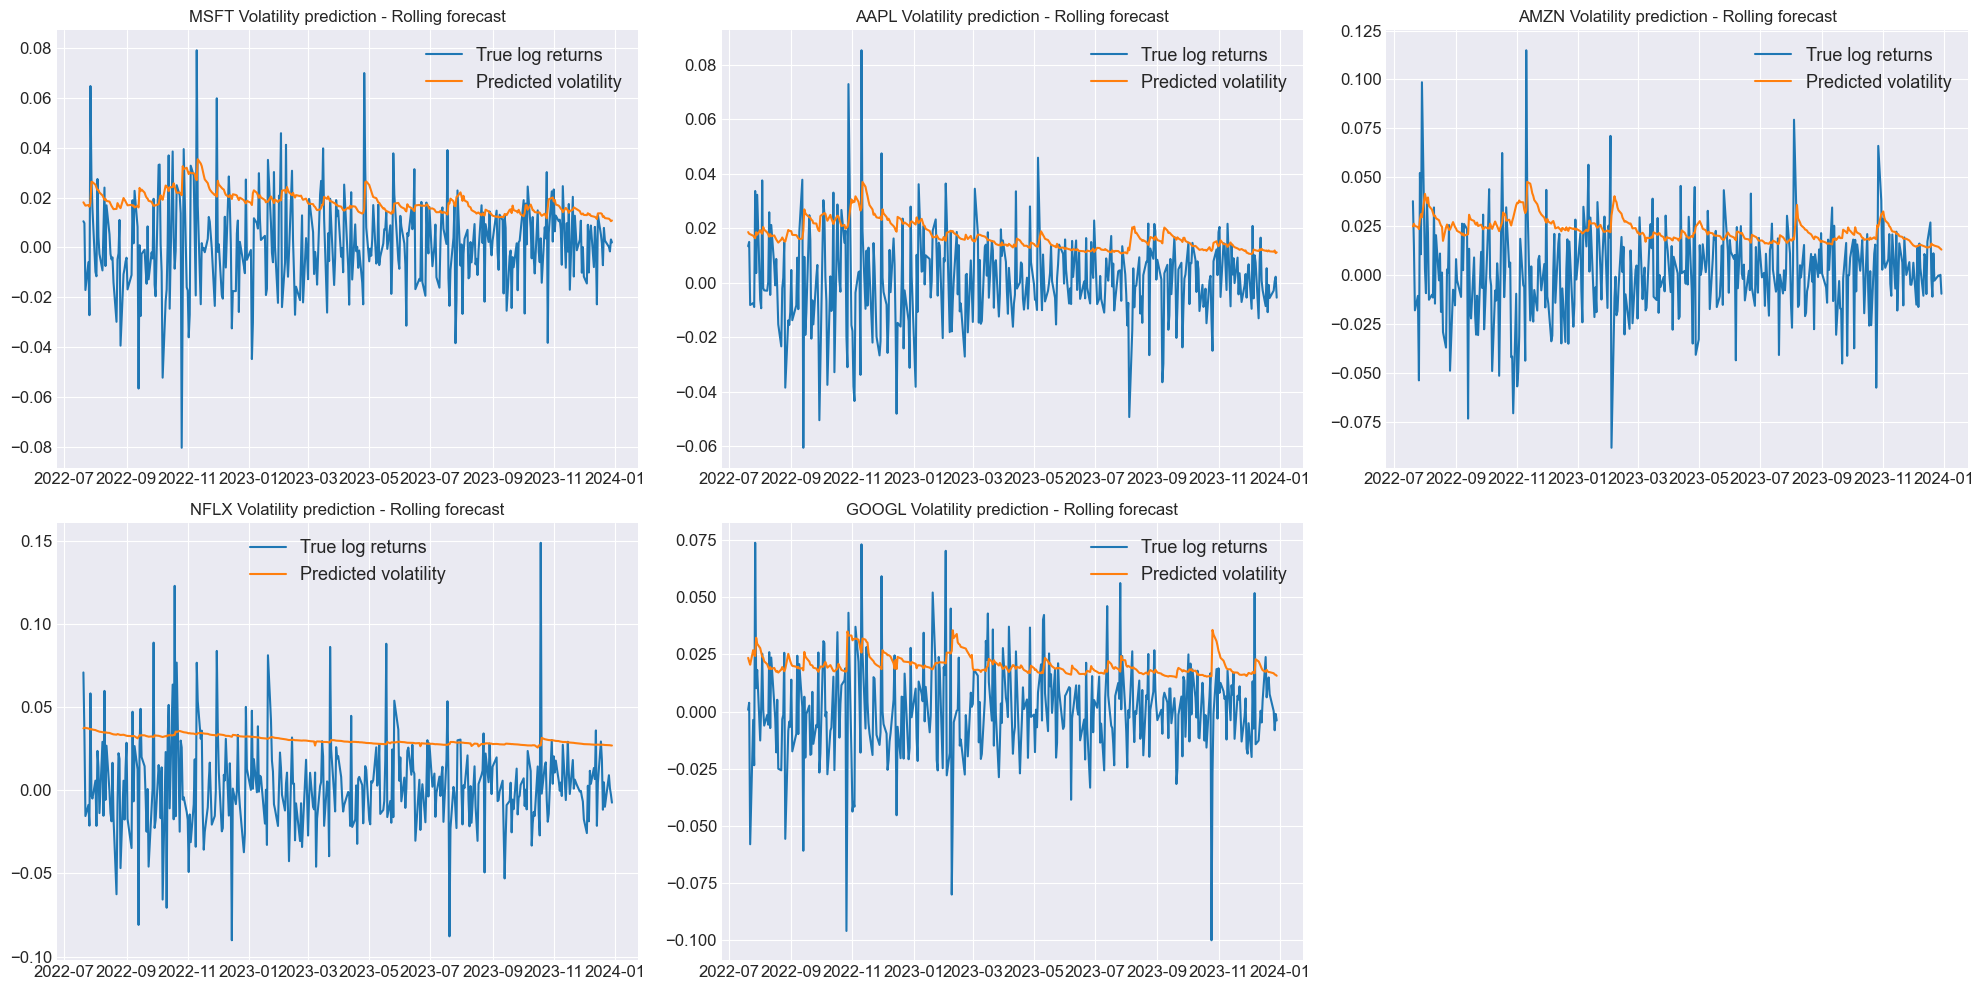

In [ ]:
test_size = 365
from arch.__future__ import reindexing

plt.figure(figsize=(20, 10))
for j, stock in enumerate(maang_log_returns.columns):
    rolling_predictions = []
    forecast_values = []

    for i in range(test_size):
        train = maang_log_returns[stock][:-(test_size-i)]
        model = arch_model(train, p=1, q=1, rescale=False)
        model_fit = model.fit(disp='off')
        pred_vol = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred_vol.variance.values[-1,:][0]))

    rolling_predictions = pd.Series(rolling_predictions, index=maang_log_returns[stock].index[-365:])


    plt.subplot(2, 3, j + 1)
    true, = plt.plot(maang_log_returns[stock][-365:])
    pred_vol, = plt.plot(rolling_predictions)

    plt.title(stock + ' Volatility prediction - Rolling forecast')
    plt.legend(['True log returns', 'Predicted volatility'], loc='best')

plt.tight_layout()
plt.show()

model a changer pour NFLX ??

##### **Processus de Hawkes** (juste a optimiser une formule selon une contrainte (utiliser un solver ?))

##### **Mean-fields** (smail)